In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import colors

In [250]:
def absLoss(true:float,pred:float):
    #print(true)
    #print(pred)
    #set up a loss function beased on absolute value, gradient is sign of pred-true
    #trueProto = tf.make_tensor_proto(true)
    #predProto = tf.make_tensor_proto(pred)
    #trueValues = tf.make_ndarray(trueProto)
    #predictedValues =  tf.make_ndarray(predProto)
    #print(predictedValues)
    #print(trueValues)

    #predictedValues = np.reshape(predictedValues,trueValues.shape)
    #trueValues = np.reshape(trueValues,predictedValues.shape)

    loss = pred-true
    #print(loss)
    #print()
    
    #gradient = np.zeros(loss.shape)
    gradient = 2*loss
    loss = loss**2

    #loss_tensor = tf.convert_to_tensor(loss,dtype='float32')
    #gradient_tensor = tf.convert_to_tensor(gradient,dtype='float32')

    return loss,gradient

size = 1
v1 = tf.convert_to_tensor(np.random.normal(0,1,size=(size,1)))
v2 = tf.convert_to_tensor(np.random.normal(0,1,size=(size)))

print(v1)
print()
print(v2)
print()
l,g = absLoss(v1,v2)
l2 = tf.keras.losses.MSE(v1,v2)
print(l)
print(l2)
print()
print(g)

tf.Tensor([[-0.25453454]], shape=(1, 1), dtype=float64)

tf.Tensor([0.16637116], shape=(1,), dtype=float64)

tf.Tensor([[0.1771616]], shape=(1, 1), dtype=float64)
tf.Tensor([0.1771616], shape=(1,), dtype=float64)

tf.Tensor([[0.84181138]], shape=(1, 1), dtype=float64)


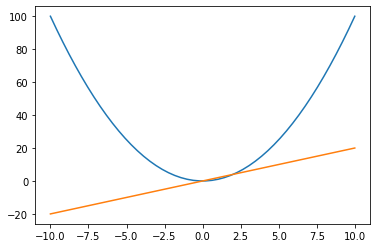

In [252]:
x1 = np.linspace(-10,10,50)
y_array = []
grad_array = []
for num in x1:
    loss,grad = absLoss(0,num)
    y_array.append(loss)
    grad_array.append(grad)


plt.plot(x1,y_array)
plt.plot(x1,grad_array)
plt.show()

In [213]:
#define model
def BuildModel(degree):
    weightInitializer = tf.keras.initializers.RandomNormal(-2,3)
    Input_x = tf.keras.layers.Input(shape=(degree),name="x")

    #denseLayer = tf.keras.layers.Dense(degree,kernel_initializer=weightInitializer)(Input_x)
    #denseLayer = tf.keras.layers.Dense(degree,kernel_initializer=weightInitializer)(denseLayer)
    #denseLayer = tf.keras.layers.Dense(degree)(denseLayer)
    #denseLayer = tf.keras.layers.Dense(degree)(denseLayer)
    outputLayer = tf.keras.layers.Dense(1,kernel_initializer=weightInitializer)(Input_x)
    
    return tf.keras.Model(inputs= Input_x,outputs=outputLayer)

class Model_m9(tf.keras.Model):
    def __init__(self,degree):
        super(Model_m9, self).__init__()
        self.model = BuildModel(degree)

    def call(self,data,training = False):
        return self.model(data)

In [5]:
#function for trainin on
# f(x) = sin(x) * e**x

def f(x,noise:float=0):
    return np.add(np.add(np.sin(1.5*np.pi*x-0.5), np.exp(x)), np.random.normal(0,noise,size=x.shape))

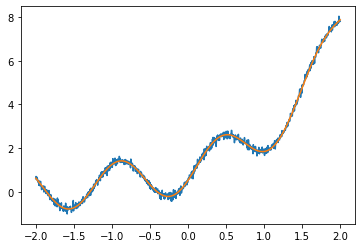

In [203]:
minVal = -2
maxVal = 2


x = np.linspace(minVal,maxVal,num=1000)
y1 = f(x,.1)
y2 = f(x)

plt.plot(x,y1)
plt.plot(x,y2)

In [276]:
PolyDegree = 1
numPoints = 10
x_forModel = np.polynomial.polynomial.polyvander(np.random.uniform(minVal,maxVal,size=numPoints),PolyDegree)
y_forModel = f(x_forModel[:,1],noise=.1)
print(x_forModel.shape)

(10, 2)


In [277]:
model = Model_m9(PolyDegree+1)#add one for the constant
model.compile()#, loss= CustomTensorFlowLoss())
print(model.model.summary())
print()
print(model.trainable_weights)
lossArray = []


Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 2)]               0         
                                                                 
 dense_89 (Dense)            (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
None

[<tf.Variable 'dense_89/kernel:0' shape=(2, 1) dtype=float32, numpy=
array([[-4.6147804],
       [-4.909621 ]], dtype=float32)>, <tf.Variable 'dense_89/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]


32/32 [==============================] - 0s 871us/step
(1000, 1)


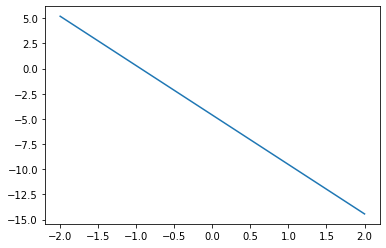

In [278]:

x = np.linspace(minVal,maxVal,num=1000)
y_pred = model.predict(np.polynomial.polynomial.polyvander(x,PolyDegree))
print(y_pred.shape)
plt.plot(x,y_pred)


In [279]:
decaySteps = len(y_forModel)
print(decaySteps)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=.01,decay_steps=decaySteps,decay_rate=0.8,staircase=False)
#lr_schedule = 0.000001
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)#lr_schedule)
optimizer = tf.keras.optimizers.SGD(1e-8)


10


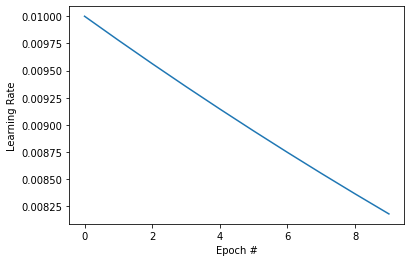

In [280]:

ep = np.arange(decaySteps,dtype='int32')
lrs = []
for i in ep:
    lrs.append(lr_schedule(i))

# the learning rate schedule
plt.plot(ep, lrs)
#plt.yscale('log')
plt.xlabel("Epoch #")
plt.ylabel("Learning Rate")
plt.show()


In [281]:
print(x_forModel[0])
print(f(x_forModel[0]))


[ 1.         -1.42923855]
[ 1.84069927 -0.57505277]


In [282]:

y_pred = model.model(np.reshape(x_forModel[0,:],(1,PolyDegree+1)), training=True)
print(y_pred)

tf.Tensor([[2.4022388]], shape=(1, 1), dtype=float32)


In [292]:
@tf.custom_gradient
def loss_fn(y_true,y_pred):
    #create the vectors to hold the values for loss and gradient
    #print("input1:{}\n\nInput2:{}".format(y_true,y_pred))
    loss_array = np.zeros(y_pred.shape)
    grad_array = np.zeros(y_pred.shape)
    mean_normalizer = 1/len(y_true)
    for i in range(len(y_true)):
        t = float(y_true[i])
        p = float(y_pred[i])
        lossVal, gradVal = absLoss(t,p)
        #print("\tloss {} ({},{}) has val: {} and gradient {}".format(i,t,p,lossVal,gradVal))
        loss_array[i] = lossVal#*mean_normalizer
        grad_array[i] = gradVal#*mean_normalizer
    
    #print("Converting to tensor")
    lossTensor = tf.convert_to_tensor(loss_array,dtype='float32')
    #lossTensor = tf.squeeze(lossTensor)
    gradTensor = tf.convert_to_tensor(grad_array,dtype='float32')
    #gradTensor = tf.squeeze(gradTensor)
    #print("loss: {}\nGrad: {}".format(lossTensor,gradTensor))
    #print("lossval and grad=",lossVal,gradVal)
    def grad(upstream):
        #print("\tGradient parameters:\n",upstream)
        pred_grad = (upstream * gradTensor)
        #var_grad = upstream * tf.constant(1)
        #print("\tPredGrad = ",pred_grad)
        return pred_grad,pred_grad
    
    #print("lossVal = ",lossVal)
    return lossTensor, grad


@tf.custom_gradient
def foo_custom_grad(x):
    y = np.square(x)
    def grad_fn(dy):
        grad = 2 * np.array(x)
        return grad * dy
    return y, grad_fn

@tf.custom_gradient
def custom_operation(x, y):
    print("custom operation:",x,y)
    # define the gradient
    def grad(g):
        
        print("\tcustomGrad:",g)
        return g, g
    
    forward_pass = x * y
    print("Forward pass:",forward_pass)

    return forward_pass, grad

In [290]:

   
dataPointNumber = 0
dataPoint_x = x_forModel#np.reshape(x_forModel[dataPointNumber,:],(1,PolyDegree+1))
dataPoint_y = y_forModel#[dataPointNumber]

print(dataPoint_x)
print(dataPoint_y)

# Iterate over the batches of the dataset.

# Open a GradientTape to record the operations run
# during the forward pass, which enables auto-differentiation.
with tf.GradientTape(persistent=True) as tape:

    # Run the forward pass of the layer.
    # The operations that the layer applies
    # to its inputs are going to be recorded
    # on the GradientTape.
    y_pred = model.model(dataPoint_x, training=True)  # Logits for this minibatch
    
    #with tape.stop_recording(): 
    print("\nypred:",y_pred)
    loss_value = loss_fn(dataPoint_y,y_pred)
    #loss_value = custom_operation(y_forModel,y_pred)
    #loss_value = foo_custom_grad(y_pred)
    print("\nabs loss:",loss_value)
    loss_value_mse = tf.keras.losses.MSE(y_forModel,y_pred)
        
    print("\nmseLoss:",loss_value_mse)
    #print(loss_gradient)

layerGrad = tape.gradient(loss_value,y_pred,unconnected_gradients='zero')
layerGrad2 = tape.gradient(loss_value_mse,y_pred,unconnected_gradients='zero')
#layerGrad_var = tf.Variable(layerGrad)
#layerGrad_var.assign(loss_gradient)
#layerGrad[0] = loss_gradient
#print(layerGrad_var)
print("Loss gradient:",layerGrad)
print()
print("Loss gradient MSE:",layerGrad2)

# Use the gradient tape to automatically retrieve
# the gradients of the trainable variables with respect to the loss.
grads = tape.gradient(loss_value, model.trainable_weights)#,output_gradients=loss_gradient,unconnected_gradients='zero')

#grads = tape.gradient(loss_value, model.trainable_weights,unconnected_gradients='zero')

#print()
print("\nGradients:",grads)

grads = tape.gradient(loss_value_mse, model.trainable_weights)#,output_gradients=loss_gradient,unconnected_gradients='zero')
print("\nGradients MSE:",grads)
#print()

del tape

[[ 1.         -1.42923855]
 [ 1.         -0.99649347]
 [ 1.         -1.87465944]
 [ 1.          0.2324625 ]
 [ 1.          1.4573077 ]
 [ 1.         -1.13917901]
 [ 1.         -0.23628401]
 [ 1.         -1.99706924]
 [ 1.          1.94266556]
 [ 1.         -0.73403185]]
[-0.5127159   1.24175088  0.16409725  1.8670805   4.14266228  0.85840861
 -0.40973739  0.49531147  7.63160635  1.20831643]

ypred: tf.Tensor(
[[  2.4022388 ]
 [  0.2776246 ]
 [  4.5890865 ]
 [ -5.756083  ]
 [-11.7696085 ]
 [  0.97815657]
 [ -3.4547155 ]
 [  5.190072  ]
 [-14.152532  ]
 [ -1.0109625 ]], shape=(10, 1), dtype=float32)

abs loss: tf.Tensor(
[[8.4969616e+00]
 [9.2953944e-01]
 [1.9580530e+01]
 [5.8112621e+01]
 [2.5320036e+02]
 [1.4339572e-02]
 [9.2718916e+00]
 [2.2040777e+01]
 [4.7454868e+02]
 [4.9251990e+00]], shape=(10, 1), dtype=float32)

mseLoss: tf.Tensor(
[  6.0867167   7.483635   14.077391   60.675682  186.13615     6.025426
  31.797766   17.948824  255.85928    12.729078 ], shape=(10,), dtype=float32)

In [244]:
class CustomTensorflowLoss(tf.keras.losses.Loss):
    def __init__(self):
        super(CustomTensorflowLoss,self).__init__()
    
    def call(self,y_true,y_pred):
        return loss_fn(y_true,y_pred)

In [228]:

epochs = 500 
batchSize = numPoints//epochs
#loss_fn = CustomTensorFlowLoss()
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    batchLoss = []
    batchGradients = []
    for batchNum in range(batchSize):
        dataPoint_x = np.reshape(x_forModel[epoch*batchSize + batchNum,:],(1,PolyDegree+1))
        dataPoint_y = y_forModel[epoch*batchSize + batchNum]

        #print(dataPoint_x)
        #print(dataPoint_y)

        # Iterate over the batches of the dataset.

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape(persistent=True) as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            y_pred = model.model(dataPoint_x, training=True)  # Logits for this minibatch
            
            #with tape.stop_recording(): 
            #print("\nypred:",y_pred)
            loss_value = loss_fn(dataPoint_y,y_pred)
            #loss_value = custom_operation(y_forModel,y_pred)
            #loss_value = foo_custom_grad(y_pred)
            #print("\nabs loss:",loss_value)
            #loss_value = tf.keras.losses.MSE(y_forModel,y_pred)
            batchLoss.append(float(np.mean(loss_value)))
                
            #print("\nmseLoss:",loss_value)
            #print(loss_gradient)

        #layerGrad = tape.gradient(loss_value,y_pred,unconnected_gradients='zero')
        #layerGrad_var = tf.Variable(layerGrad)
        #layerGrad_var.assign(loss_gradient)
        #layerGrad[0] = loss_gradient
        #print(layerGrad_var)
        #print(layerGrad)
        
        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        #grads = tape.gradient(loss_value, model.trainable_weights)#,output_gradients=loss_gradient,unconnected_gradients='zero')
        if(batchNum == 0):
            grads = tape.gradient(loss_value, model.trainable_weights,unconnected_gradients='zero')
        else:
            grads += tape.gradient(loss_value, model.trainable_weights,unconnected_gradients='zero')
        #print()
        #print("\nGradients:",grads)
        #print()
        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        
    optimizer.apply_gradients(zip(grads,model.trainable_weights))
    #print(model.trainable_weights)

    # Log every 200 batches.
    lossArray.append(float(np.mean(batchLoss)))
    print(
        "Training loss at epoch {}: {:.4f}".format(epoch, lossArray[-1]))  
    
    #print("Seen so far: %s samples" % ((step + 1) * batch_size))
del tape


Start of epoch 0
Training loss at epoch 0: 1687209.3825

Start of epoch 1
Training loss at epoch 1: 1672038.5676

Start of epoch 2
Training loss at epoch 2: 2204870.8627

Start of epoch 3
Training loss at epoch 3: 1056039.2288

Start of epoch 4
Training loss at epoch 4: 1734343.4255

Start of epoch 5
Training loss at epoch 5: 1232151.9421

Start of epoch 6
Training loss at epoch 6: 366256.4282

Start of epoch 7
Training loss at epoch 7: 739313.8892

Start of epoch 8
Training loss at epoch 8: 158020.2860

Start of epoch 9
Training loss at epoch 9: 929422.8596

Start of epoch 10
Training loss at epoch 10: 34510.1218

Start of epoch 11
Training loss at epoch 11: 1781059.6742

Start of epoch 12
Training loss at epoch 12: 1041282.1029

Start of epoch 13
Training loss at epoch 13: 878952.0442

Start of epoch 14
Training loss at epoch 14: 167216.6200

Start of epoch 15
Training loss at epoch 15: 28064.5252

Start of epoch 16
Training loss at epoch 16: 1173756.0450

Start of epoch 17
Training

In [ ]:
print(model.trainable_weights)

In [294]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-8),loss=tf.keras.losses.MSE)
hist = model.fit(x_forModel,y_forModel,
                 epochs=1,
                 #validation_split=.1,
                 shuffle=True)

1/1 [==============================] - 0s 226ms/step - loss: 85.1121


In [197]:
def plotHistory(hist):
    fig,ax = plt.subplots(1,1)
    ax.set_title("")
    keys = hist.history.keys()
    y = np.arange(1,hist.params['epochs']+1)
    for key in keys:
        if('output' in key):
            minVal = min(hist.history[key])
            meanVal = np.mean(hist.history[key])
            maxVal = max(hist.history[key])
            if(minVal != maxVal):
                print("{}:\n\tmin:{}\n\tmean:{}\n\tmax:{}".format(key,minVal,meanVal,maxVal))
                #ax.plot(y,hist.history[key],linewidth=0.5,label=key)
        else:
            ax.plot(y,hist.history[key],label=key)
            minVal = min(hist.history[key])
            meanVal = np.mean(hist.history[key])
            maxVal = max(hist.history[key])
            print("{}:\n\tmin:{}\n\tmean:{}\n\tmax:{}".format(key,minVal,meanVal,maxVal))
    
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.show()

loss:
	min:989.6104736328125
	mean:29125.4051184082
	max:778574.375
val_loss:
	min:852.0269775390625
	mean:24308.347082519533
	max:617865.375


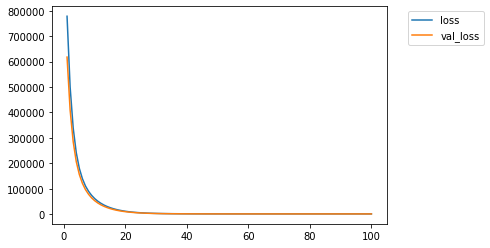

In [232]:
plotHistory(hist)

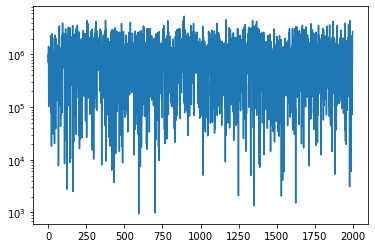

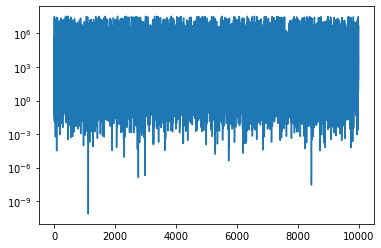

In [229]:
plt.plot(np.arange(len(lossArray)),lossArray)
plt.yscale('log')
plt.show()
plt.plot(np.arange(len(lossOfAllTrainings)),lossOfAllTrainings)
plt.yscale('log')
plt.show()

32/32 [==============================] - 0s 871us/step
(1000, 1)


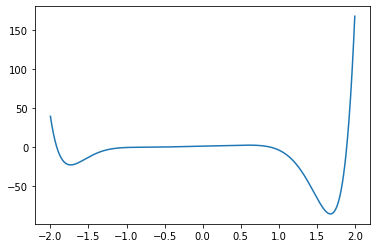

In [233]:
#visualizeOutputs

y_pred = model.predict(np.polynomial.polynomial.polyvander(x,PolyDegree))
print(y_pred.shape)
plt.plot(x,y_pred)